In [1]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn, optim
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# -----------------------
# Device Setup
# -----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [3]:
# -----------------------
# Load Metadata
# -----------------------
csv_path = r'C:\Users\jazil\OneDrive\Desktop\GroundTruth.csv'  # Update this path
image_dir = r'C:\Users\jazil\OneDrive\Desktop\DermaDetectAI\images'         # Update this path
meta_df = pd.read_csv(csv_path)

# Ensure correct columns
label_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
meta_df['label'] = meta_df[label_columns].values.tolist()  # One-hot list

In [4]:
# -----------------------
# Custom Dataset
# -----------------------
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image'] + '.jpg')
        image = Image.open(img_path).convert('RGB')

        label = torch.tensor(row['label'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# -----------------------
# Data Transforms & Split
# -----------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_df, val_df = train_test_split(meta_df, test_size=0.2, stratify=meta_df[label_columns].values, random_state=42)

train_dataset = HAM10000Dataset(train_df, image_dir, transform)
val_dataset = HAM10000Dataset(val_df, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [6]:
# -----------------------
# Model Setup
# -----------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [7]:
# -----------------------
# Training Loop (Multilabel)
# -----------------------
EPOCHS = 30
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1} - Training Loss: {train_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.numel()

    print(f"Epoch {epoch+1} - Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / total:.4f}")

    # Save model checkpoint
    if (correct / total) > best_acc:
        best_acc = correct / total
        torch.save(model.state_dict(), "resnet_multiclass_best.pth")
        print(f"🔥 Best model saved with accuracy: {best_acc:.4f}")

Epoch 1/30: 100%|██████████| 251/251 [01:01<00:00,  4.10it/s]


Epoch 1 - Training Loss: 0.1946
Epoch 1 - Validation Loss: 0.1300, Accuracy: 0.9498
🔥 Best model saved with accuracy: 0.9498


Epoch 2/30: 100%|██████████| 251/251 [01:00<00:00,  4.15it/s]


Epoch 2 - Training Loss: 0.1011
Epoch 2 - Validation Loss: 0.1337, Accuracy: 0.9506
🔥 Best model saved with accuracy: 0.9506


Epoch 3/30: 100%|██████████| 251/251 [01:00<00:00,  4.15it/s]


Epoch 3 - Training Loss: 0.0557
Epoch 3 - Validation Loss: 0.1160, Accuracy: 0.9579
🔥 Best model saved with accuracy: 0.9579


Epoch 4/30: 100%|██████████| 251/251 [01:01<00:00,  4.06it/s]


Epoch 4 - Training Loss: 0.0265
Epoch 4 - Validation Loss: 0.1259, Accuracy: 0.9566


Epoch 5/30: 100%|██████████| 251/251 [01:06<00:00,  3.76it/s]


Epoch 5 - Training Loss: 0.0182
Epoch 5 - Validation Loss: 0.1319, Accuracy: 0.9579


Epoch 6/30: 100%|██████████| 251/251 [01:11<00:00,  3.53it/s]


Epoch 6 - Training Loss: 0.0104
Epoch 6 - Validation Loss: 0.1325, Accuracy: 0.9576


Epoch 7/30: 100%|██████████| 251/251 [01:02<00:00,  4.04it/s]


Epoch 7 - Training Loss: 0.0088
Epoch 7 - Validation Loss: 0.1413, Accuracy: 0.9596
🔥 Best model saved with accuracy: 0.9596


Epoch 8/30: 100%|██████████| 251/251 [01:00<00:00,  4.15it/s]


Epoch 8 - Training Loss: 0.0093
Epoch 8 - Validation Loss: 0.1861, Accuracy: 0.9529


Epoch 9/30: 100%|██████████| 251/251 [01:00<00:00,  4.16it/s]


Epoch 9 - Training Loss: 0.0131
Epoch 9 - Validation Loss: 0.1589, Accuracy: 0.9491


Epoch 10/30: 100%|██████████| 251/251 [01:01<00:00,  4.09it/s]


Epoch 10 - Training Loss: 0.0098
Epoch 10 - Validation Loss: 0.1633, Accuracy: 0.9571


Epoch 11/30: 100%|██████████| 251/251 [01:00<00:00,  4.13it/s]


Epoch 11 - Training Loss: 0.0043
Epoch 11 - Validation Loss: 0.1507, Accuracy: 0.9596


Epoch 12/30: 100%|██████████| 251/251 [01:01<00:00,  4.11it/s]


Epoch 12 - Training Loss: 0.0026
Epoch 12 - Validation Loss: 0.1432, Accuracy: 0.9625
🔥 Best model saved with accuracy: 0.9625


Epoch 13/30: 100%|██████████| 251/251 [01:00<00:00,  4.12it/s]


Epoch 13 - Training Loss: 0.0026
Epoch 13 - Validation Loss: 0.1769, Accuracy: 0.9556


Epoch 14/30: 100%|██████████| 251/251 [01:00<00:00,  4.13it/s]


Epoch 14 - Training Loss: 0.0121
Epoch 14 - Validation Loss: 0.1862, Accuracy: 0.9547


Epoch 15/30: 100%|██████████| 251/251 [01:01<00:00,  4.11it/s]


Epoch 15 - Training Loss: 0.0103
Epoch 15 - Validation Loss: 0.1503, Accuracy: 0.9571


Epoch 16/30: 100%|██████████| 251/251 [01:01<00:00,  4.09it/s]


Epoch 16 - Training Loss: 0.0067
Epoch 16 - Validation Loss: 0.1426, Accuracy: 0.9605


Epoch 17/30: 100%|██████████| 251/251 [01:01<00:00,  4.11it/s]


Epoch 17 - Training Loss: 0.0056
Epoch 17 - Validation Loss: 0.1613, Accuracy: 0.9535


Epoch 18/30: 100%|██████████| 251/251 [01:01<00:00,  4.10it/s]


Epoch 18 - Training Loss: 0.0034
Epoch 18 - Validation Loss: 0.1421, Accuracy: 0.9634
🔥 Best model saved with accuracy: 0.9634


Epoch 19/30: 100%|██████████| 251/251 [01:01<00:00,  4.09it/s]


Epoch 19 - Training Loss: 0.0064
Epoch 19 - Validation Loss: 0.1779, Accuracy: 0.9559


Epoch 20/30: 100%|██████████| 251/251 [01:01<00:00,  4.11it/s]


Epoch 20 - Training Loss: 0.0051
Epoch 20 - Validation Loss: 0.1731, Accuracy: 0.9578


Epoch 21/30: 100%|██████████| 251/251 [01:01<00:00,  4.10it/s]


Epoch 21 - Training Loss: 0.0024
Epoch 21 - Validation Loss: 0.1446, Accuracy: 0.9630


Epoch 22/30: 100%|██████████| 251/251 [01:02<00:00,  4.05it/s]


Epoch 22 - Training Loss: 0.0041
Epoch 22 - Validation Loss: 0.1935, Accuracy: 0.9574


Epoch 23/30: 100%|██████████| 251/251 [01:01<00:00,  4.10it/s]


Epoch 23 - Training Loss: 0.0048
Epoch 23 - Validation Loss: 0.1731, Accuracy: 0.9597


Epoch 24/30: 100%|██████████| 251/251 [01:01<00:00,  4.10it/s]


Epoch 24 - Training Loss: 0.0069
Epoch 24 - Validation Loss: 0.2003, Accuracy: 0.9544


Epoch 25/30: 100%|██████████| 251/251 [01:01<00:00,  4.10it/s]


Epoch 25 - Training Loss: 0.0038
Epoch 25 - Validation Loss: 0.1779, Accuracy: 0.9562


Epoch 26/30: 100%|██████████| 251/251 [01:01<00:00,  4.11it/s]


Epoch 26 - Training Loss: 0.0045
Epoch 26 - Validation Loss: 0.1680, Accuracy: 0.9603


Epoch 27/30: 100%|██████████| 251/251 [01:01<00:00,  4.10it/s]


Epoch 27 - Training Loss: 0.0032
Epoch 27 - Validation Loss: 0.2077, Accuracy: 0.9544


Epoch 28/30: 100%|██████████| 251/251 [01:01<00:00,  4.09it/s]


Epoch 28 - Training Loss: 0.0037
Epoch 28 - Validation Loss: 0.2489, Accuracy: 0.9526


Epoch 29/30: 100%|██████████| 251/251 [01:00<00:00,  4.13it/s]


Epoch 29 - Training Loss: 0.0048
Epoch 29 - Validation Loss: 0.2466, Accuracy: 0.9488


Epoch 30/30: 100%|██████████| 251/251 [01:00<00:00,  4.13it/s]


Epoch 30 - Training Loss: 0.0052
Epoch 30 - Validation Loss: 0.2005, Accuracy: 0.9596


In [9]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import os

# Assume you have these already:
# model, optimizer, criterion, train_loader, val_loader, device

EPOCHS = 30
scaler = GradScaler()
best_val_loss = float("inf")
save_path = "resnet_multiclass_bestval.pth"

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

    # ----- Validation -----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            targets = torch.argmax(labels, dim=1)
            correct += (preds == targets).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"📉 Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # ----- Save Best Model -----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"💾 Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")


C:\Users\Mohammed Riyaz\AppData\Local\Temp\ipykernel_3592\1252069946.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/30 - Training:   0%|          | 0/251 [00:00<?, ?it/s]C:\Users\Mohammed Riyaz\AppData\Local\Temp\ipykernel_3592\1252069946.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30 - Training: 100%|██████████| 251/251 [00:58<00:00,  4.32it/s]
C:\Users\Mohammed Riyaz\AppData\Local\Temp\ipykernel_3592\1252069946.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✅ Epoch 1 - Training Loss: 0.1846
📉 Epoch 1 - Validation Loss: 0.1524, Accuracy: 0.7898
💾 Best model saved at epoch 1 with val loss 0.1524


Epoch 2/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.67it/s]


✅ Epoch 2 - Training Loss: 0.0927
📉 Epoch 2 - Validation Loss: 0.1202, Accuracy: 0.8278
💾 Best model saved at epoch 2 with val loss 0.1202


Epoch 3/30 - Training: 100%|██████████| 251/251 [00:57<00:00,  4.36it/s]


✅ Epoch 3 - Training Loss: 0.0492
📉 Epoch 3 - Validation Loss: 0.1144, Accuracy: 0.8482
💾 Best model saved at epoch 3 with val loss 0.1144


Epoch 4/30 - Training: 100%|██████████| 251/251 [00:57<00:00,  4.35it/s]


✅ Epoch 4 - Training Loss: 0.0200
📉 Epoch 4 - Validation Loss: 0.1281, Accuracy: 0.8562


Epoch 5/30 - Training: 100%|██████████| 251/251 [00:52<00:00,  4.76it/s]


✅ Epoch 5 - Training Loss: 0.0161
📉 Epoch 5 - Validation Loss: 0.1410, Accuracy: 0.8303


Epoch 6/30 - Training: 100%|██████████| 251/251 [00:52<00:00,  4.75it/s]


✅ Epoch 6 - Training Loss: 0.0155
📉 Epoch 6 - Validation Loss: 0.1332, Accuracy: 0.8517


Epoch 7/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 7 - Training Loss: 0.0083
📉 Epoch 7 - Validation Loss: 0.1258, Accuracy: 0.8682


Epoch 8/30 - Training: 100%|██████████| 251/251 [00:52<00:00,  4.76it/s]


✅ Epoch 8 - Training Loss: 0.0093
📉 Epoch 8 - Validation Loss: 0.1418, Accuracy: 0.8517


Epoch 9/30 - Training: 100%|██████████| 251/251 [00:52<00:00,  4.76it/s]


✅ Epoch 9 - Training Loss: 0.0119
📉 Epoch 9 - Validation Loss: 0.2053, Accuracy: 0.8213


Epoch 10/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.71it/s]


✅ Epoch 10 - Training Loss: 0.0074
📉 Epoch 10 - Validation Loss: 0.1247, Accuracy: 0.8642


Epoch 11/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.70it/s]


✅ Epoch 11 - Training Loss: 0.0093
📉 Epoch 11 - Validation Loss: 0.1834, Accuracy: 0.8337


Epoch 12/30 - Training: 100%|██████████| 251/251 [00:52<00:00,  4.75it/s]


✅ Epoch 12 - Training Loss: 0.0077
📉 Epoch 12 - Validation Loss: 0.1569, Accuracy: 0.8512


Epoch 13/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 13 - Training Loss: 0.0059
📉 Epoch 13 - Validation Loss: 0.1325, Accuracy: 0.8702


Epoch 14/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 14 - Training Loss: 0.0040
📉 Epoch 14 - Validation Loss: 0.1466, Accuracy: 0.8722


Epoch 15/30 - Training: 100%|██████████| 251/251 [00:52<00:00,  4.74it/s]


✅ Epoch 15 - Training Loss: 0.0022
📉 Epoch 15 - Validation Loss: 0.1477, Accuracy: 0.8582


Epoch 16/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 16 - Training Loss: 0.0055
📉 Epoch 16 - Validation Loss: 0.1885, Accuracy: 0.8402


Epoch 17/30 - Training: 100%|██████████| 251/251 [00:52<00:00,  4.74it/s]


✅ Epoch 17 - Training Loss: 0.0103
📉 Epoch 17 - Validation Loss: 0.1439, Accuracy: 0.8492


Epoch 18/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.72it/s]


✅ Epoch 18 - Training Loss: 0.0085
📉 Epoch 18 - Validation Loss: 0.2218, Accuracy: 0.8213


Epoch 19/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 19 - Training Loss: 0.0049
📉 Epoch 19 - Validation Loss: 0.1586, Accuracy: 0.8572


Epoch 20/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 20 - Training Loss: 0.0016
📉 Epoch 20 - Validation Loss: 0.1433, Accuracy: 0.8667


Epoch 21/30 - Training: 100%|██████████| 251/251 [00:52<00:00,  4.74it/s]


✅ Epoch 21 - Training Loss: 0.0028
📉 Epoch 21 - Validation Loss: 0.1882, Accuracy: 0.8462


Epoch 22/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.71it/s]


✅ Epoch 22 - Training Loss: 0.0091
📉 Epoch 22 - Validation Loss: 0.2005, Accuracy: 0.8447


Epoch 23/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 23 - Training Loss: 0.0081
📉 Epoch 23 - Validation Loss: 0.2138, Accuracy: 0.8288


Epoch 24/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.72it/s]


✅ Epoch 24 - Training Loss: 0.0036
📉 Epoch 24 - Validation Loss: 0.1800, Accuracy: 0.8487


Epoch 25/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.72it/s]


✅ Epoch 25 - Training Loss: 0.0017
📉 Epoch 25 - Validation Loss: 0.1432, Accuracy: 0.8722


Epoch 26/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.72it/s]


✅ Epoch 26 - Training Loss: 0.0027
📉 Epoch 26 - Validation Loss: 0.1771, Accuracy: 0.8487


Epoch 27/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 27 - Training Loss: 0.0052
📉 Epoch 27 - Validation Loss: 0.1817, Accuracy: 0.8372


Epoch 28/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


✅ Epoch 28 - Training Loss: 0.0085
📉 Epoch 28 - Validation Loss: 0.1728, Accuracy: 0.8402


Epoch 29/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.72it/s]


✅ Epoch 29 - Training Loss: 0.0042
📉 Epoch 29 - Validation Loss: 0.1807, Accuracy: 0.8562


Epoch 30/30 - Training: 100%|██████████| 251/251 [00:53<00:00,  4.72it/s]


✅ Epoch 30 - Training Loss: 0.0012
📉 Epoch 30 - Validation Loss: 0.2168, Accuracy: 0.8417


In [10]:
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.metrics import classification_report
import pandas as pd
from tqdm import tqdm

# ---------------------------
# CONFIGURATION
# ---------------------------
model_path = "resnet_multiclass_bestval.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set this to your 7-class label map
label_map = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}

# ---------------------------
# LOAD MODEL
# ---------------------------
from torchvision.models import resnet18

model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ---------------------------
# LOAD DATA
# ---------------------------
# Assuming you already have a DataLoader for test or validation
# For example: val_loader

# ---------------------------
# EVALUATION
# ---------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# ---------------------------
# REPORT
# ---------------------------
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[label_map[i] for i in range(7)]))


Evaluating: 100%|██████████| 63/63 [00:11<00:00,  5.26it/s]


📊 Classification Report:

              precision    recall  f1-score   support

         MEL       0.67      0.48      0.56       223
          NV       0.89      0.97      0.93      1341
         BCC       0.77      0.78      0.77       103
       AKIEC       0.66      0.58      0.62        65
         BKL       0.85      0.60      0.70       220
          DF       0.82      0.61      0.70        23
        VASC       0.73      0.96      0.83        28

    accuracy                           0.85      2003
   macro avg       0.77      0.71      0.73      2003
weighted avg       0.84      0.85      0.84      2003



In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from sklearn.metrics import classification_report
from tqdm import tqdm

# ---------------------------
# CONFIGURATION
# ---------------------------
model_path = "resnet_multiclass_bestval.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_map = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}
target_names = [label_map[i] for i in range(7)]

# ---------------------------
# LOAD MODEL
# ---------------------------
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7-class output
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded successfully.")

✅ Model loaded successfully.


In [14]:
# ---------------------------
# EVALUATE
# ---------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# ---------------------------
# REPORT
# ---------------------------
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))

Evaluating: 100%|██████████| 63/63 [02:05<00:00,  1.99s/it]


📊 Classification Report:

              precision    recall  f1-score   support

         MEL       0.67      0.48      0.56       223
          NV       0.89      0.97      0.93      1341
         BCC       0.77      0.78      0.77       103
       AKIEC       0.66      0.58      0.62        65
         BKL       0.85      0.60      0.70       220
          DF       0.82      0.61      0.70        23
        VASC       0.73      0.96      0.83        28

    accuracy                           0.85      2003
   macro avg       0.77      0.71      0.73      2003
weighted avg       0.84      0.85      0.84      2003



Evaluating for ROC/AUC: 100%|██████████| 63/63 [01:44<00:00,  1.66s/it]


<Figure size 800x600 with 0 Axes>

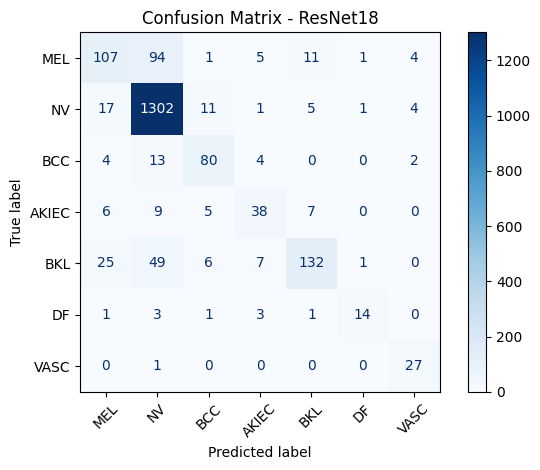


📊 ROC AUC Scores:
MEL: 0.9131
NV: 0.9636
BCC: 0.9843
AKIEC: 0.9782
BKL: 0.9558
DF: 0.9865
VASC: 0.9987
Macro AUC: 0.9686
Weighted AUC: 0.9594


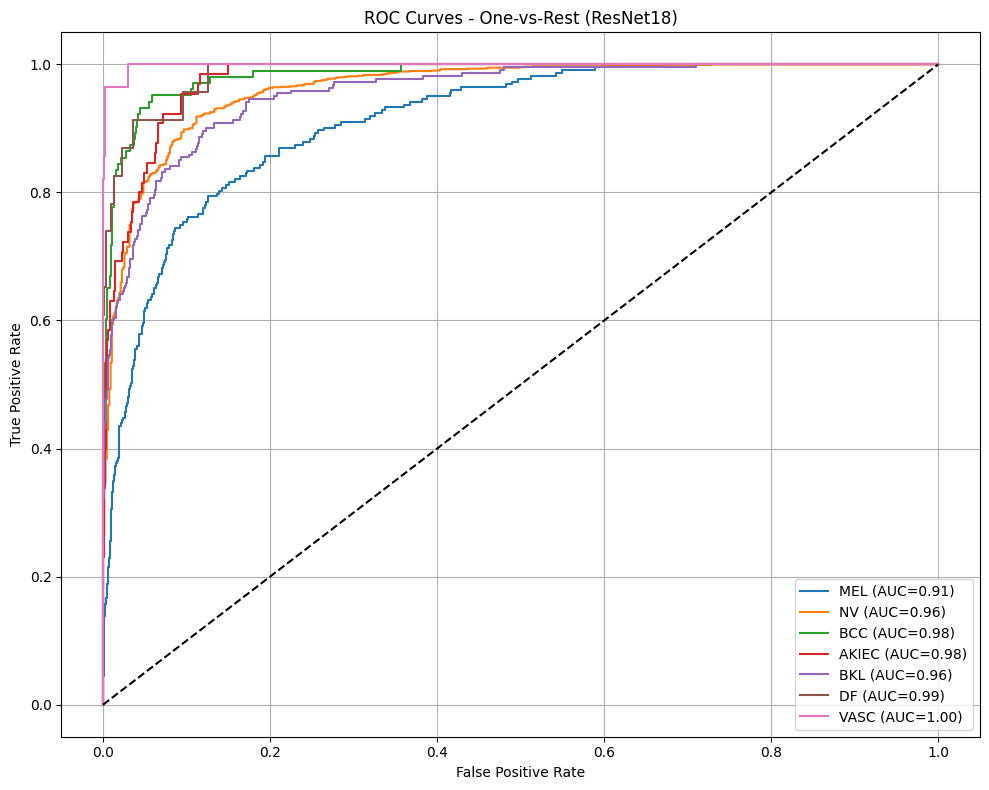

In [15]:
import torch.nn.functional as F
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 📍 Must match your label order
labels_str = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

all_preds = []
all_labels = []
all_probs = []
all_true_onehot = []

# 🧠 Get predictions & probabilities
model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating for ROC/AUC"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)
        true_labels = torch.argmax(labels, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_true_onehot.extend(labels.cpu().numpy())

# ================================
# 🟦 Confusion Matrix
# ================================
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_str)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - ResNet18")
plt.tight_layout()
plt.show()

# ================================
# 📈 ROC AUC Scores
# ================================
y_true_bin = np.array(all_true_onehot)
y_probs = np.array(all_probs)

auc_per_class = roc_auc_score(y_true_bin, y_probs, average=None)
auc_macro = roc_auc_score(y_true_bin, y_probs, average='macro')
auc_weighted = roc_auc_score(y_true_bin, y_probs, average='weighted')

print("\n📊 ROC AUC Scores:")
for i, auc in enumerate(auc_per_class):
    print(f"{labels_str[i]}: {auc:.4f}")
print(f"Macro AUC: {auc_macro:.4f}")
print(f"Weighted AUC: {auc_weighted:.4f}")

# ================================
# 📊 ROC Curves (One-vs-Rest)
# ================================
plt.figure(figsize=(10, 8))
for i in range(len(labels_str)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{labels_str[i]} (AUC={auc_per_class[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - One-vs-Rest (ResNet18)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
